In [1]:
import sys
import os
import os.path as osp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm, SymLogNorm
import math
import _pickle as pickle

import astropy.constants as ac
import astropy.units as au

sys.path.insert(0,'..')
import pyathena as pa

In [2]:
import pandas as pd

from pyathena import LoadSim
from pyathena.util.units import Units

from pyathena.tigress_ncr.hst import Hst
from pyathena.tigress_ncr.load_sim_tigress_ncr import LoadSimTIGRESSNCRAll
from pyathena.fields import fields


In [3]:
models = dict(classic = '/data/comejuliet/NCRSP/R8_8pc_NCRSP.classic.y1.b10.v3.768.xy2048.eps1.e-8/',
              ncr = '/data/comejuliet/NCRSP/R8_8pc_NCRSP.full.y1.b10.v3.768.xy2048.eps1.e-8/',
              no_spiral = '/data/comejuliet/NCRSP/R8b_8pc_NCR.full.v3.xy2048.eps1.e-8/',
              no_spiral_early = '/data/comejuliet/NCRSP/R8b_8pc_NCR.full.v3/')
              #demo = '/data/comejuliet/NCRSP/R8_8pc_NCRSP.full.y2.xy1024.eps0.np768.has/')
sa = pa.LoadSimTIGRESSNCRAll(models)

# MODELS
ncr = sa.set_model('ncr')
classic = sa.set_model('classic')
no_spiral = sa.set_model('no_spiral')
no_spiral_early = sa.set_model('no_spiral_early')

LoadSimTIGRESSNCR-WARNING: zprof files not found in /data/comejuliet/NCRSP/R8_8pc_NCRSP.full.y1.b10.v3.768.xy2048.eps1.e-8.
LoadSimTIGRESSNCR-WARNING: rst files not found in /data/comejuliet/NCRSP/R8_8pc_NCRSP.full.y1.b10.v3.768.xy2048.eps1.e-8.
/home/comejuliet/miniconda3/envs/pyathena/lib/python3.10/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
LoadSimTIGRESSNCR-WARNING: rst files not found in /data/comejuliet/NCRSP/R8_8pc_NCRSP.classic.y1.b10.v3.768.xy2048.eps1.e-8.
LoadSimTIGRESSNCR-WARNING: zprof files not found in /data/comejuliet/NCRSP/R8b_8pc_NCR.full.v3.xy2048.eps1.e-8.
LoadSimTIGRESSNCR-WARNING: rst files not found in /data/comejuliet/NCRSP/R8b_8pc_NCR.full.v3.xy2048.eps1.e-8.
LoadSimTIGRESSNCR-WARNING: vtk files 

In [4]:
#loading VTK files
s = ncr
ds = s.load_vtk(s.nums[5])
h = s.read_hst()

Text(0, 0.5, '$Q_{i}/{Area}[s^{-1}kpc^{-2}]$\n$\\Sigma_{SFR,10 Myr}x 10^{53} [M_{\\odot}kpc^-2yr^-1]$')

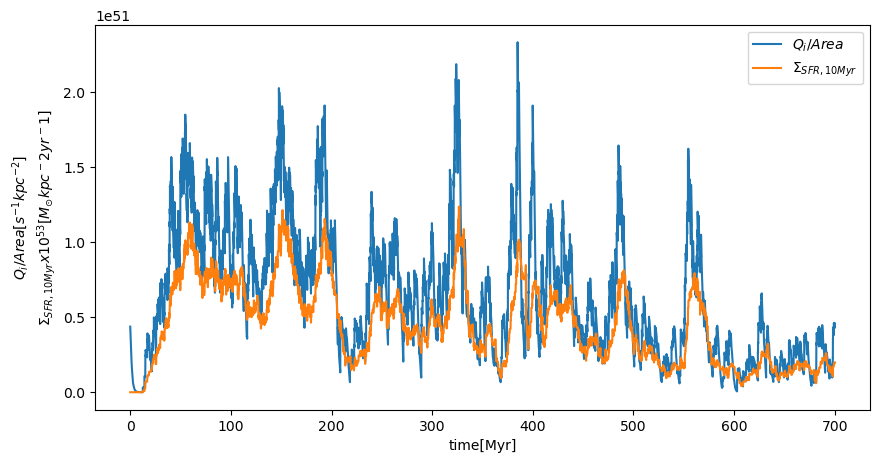

In [5]:
plt.figure(figsize=(10,5))
Lx = s.domain['Lx'][0]/10**3
Ly = s.domain['Lx'][1]/10**3
plt.plot(h['Qtot_PH']/(Lx*Ly),label='$Q_{i}/Area$')
plt.plot(h['sfr10']*1.e53, label='$\Sigma_{SFR,10Myr}$')
plt.legend()
plt.xlabel('time[Myr]')
plt.ylabel(r"$Q_{i}/{Area}[s^{-1}kpc^{-2}]$"
           "\n"
           r"$\Sigma_{SFR,10 Myr}x 10^{53} [M_{\odot}kpc^-2yr^-1]$")



## Calculation on Halpha emissivity

In [6]:
fields = ds.get_field(['T','nH','xe','j_Halpha','xHI','xH2','pressure','density'])

In [7]:
# code unit are stored as astropy.units objects
s.u.length, s.u.mass, s.u.time, s.u.velocity 

(<Quantity 1. pc>,
 <Quantity 0.03462449 solMass>,
 <Quantity 3.08567758e+13 s>,
 <Quantity 1. km / s>)

In [8]:
# To convert code time to Myr, we can multiply code_time by u.Myr
# That is, u.Myr = code.time.to('Myr').value
s.u.Myr, s.u.kms, s.u.Msun, s.u.pc, s.u.pc

(0.9777922216807893, 1.0, 0.0346244904274392, 1.0, 1.0)

In [12]:
# Halpha emissivity [erg/s/cm^-3/sr]
# Caution: Draine (2011)'s alpha_eff_Halpha valid for ~1000 K < T < ~30000 K
# Better to use this for warm gas only

hnu_Halpha = (ac.h*ac.c/(6562.8*au.angstrom)).to('erg')

# this is equivalent to T4 = fields['T']/1.e4
T4 = (fields['pressure']/(fields['density']*(1.1 + fields['xe'] - fields['xH2']))/\
                 (ac.k_B/s.u.energy_density).cgs.value)/1e4

alpha_eff_Halpha = 1.17e-13*T4**(-0.942 -0.031 * np.log(T4))

idx = (T4 > 0.1) * (T4 < 3)
 
j_Halpha = fields['nH']**2*(1.0 - fields['xHI'] - fields['xH2'])*fields['xe']*\
      alpha_eff_Halpha*hnu_Halpha/(4.0*np.pi)

In [13]:
# conversion from pc to cm
ac.pc.cgs.value

3.0856775814913674e+18

In [15]:
# since I want to obtain the surface density of SFR, it might be better to calculate
# the Halpha emissivity from the emission measure, using the data from slc and prj 
# calculation of SigmaSFR

prj = s.read_prj(s.nums[5])
slc = s.read_slc(s.nums[5])
SigmaEM = prj['z']['EM']
T = slc['z']['T']

# this is equivalent to T4 = fields['T']/1.e4
T4 = T/1.e4
# idx = (T4 > 0.1) * (T4 < 3)

alpha_eff_Halpha = 1.17e-13*T4**(-0.942 -0.031 * np.log(T4))

SigmaSFR = alpha_eff_Halpha*(ac.pc.cgs.value)**(3)*SigmaEM*hnu_Halpha*7.9e-42

In [17]:
SigmaSFR # do the values obtained make sense ? (Msun/yr/pc^2)

<Quantity [[6.48572394e-12, 6.14477364e-12, 5.93105465e-12, ...,
            8.45705645e-14, 8.11729769e-14, 8.06180823e-14],
           [6.50225941e-12, 6.06075980e-12, 5.69155131e-12, ...,
            8.66607693e-14, 8.25288410e-14, 7.54038767e-14],
           [6.64798474e-12, 6.11693797e-12, 5.79467439e-12, ...,
            8.31454701e-14, 7.78645317e-14, 7.03571496e-14],
           ...,
           [1.03798632e-11, 8.22307455e-12, 7.93624722e-12, ...,
            6.27701590e-15, 4.11851621e-14, 7.02879524e-14],
           [7.95843005e-12, 6.88580067e-12, 7.01906687e-12, ...,
            2.05468401e-14, 6.87008098e-14, 7.45677289e-14],
           [6.83809196e-12, 6.35133466e-12, 6.35238460e-12, ...,
            7.03315021e-14, 7.53223752e-14, 7.97096284e-14]] erg>

In [18]:
# now we apply the regridding procedure to the SigmaSFR just obtained

def rebin(arr, i):
    """Rebin 2D array. Coarsening by a factor of 2**i """
    f = 2**i
    new_shape =  arr.shape[0]//f, arr.shape[1]//f
    shape = (new_shape[0], f,
             new_shape[1], f)
    return arr.reshape(shape).mean(-1).mean(1)

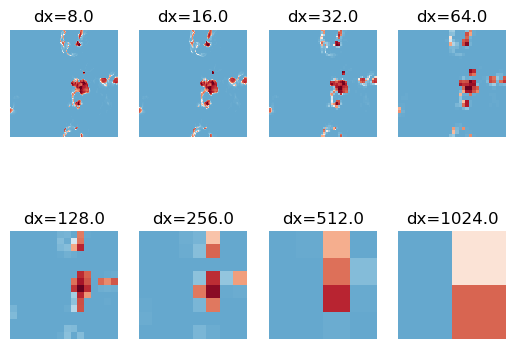

In [19]:
fig,axes = plt.subplots(2,4)
dx = s.domain['dx'][0]
for i,ax in enumerate(axes.flatten()):
    Sigma_down = rebin(SigmaSFR,i)
    dmap = Sigma_down/Sigma_down.mean()-1
    

    plt.sca(ax)
    plt.imshow(dmap,norm=SymLogNorm(0.1,vmin=-100,vmax=100),
               cmap=plt.cm.RdBu_r,interpolation='nearest')
    plt.title('dx={}'.format(dx*2**i))
    plt.axis('off')

In [22]:
# and we calculate the auto correlation function of SigmaSFR_Halpha
def get_correlation(map1,map2=None,Nbin=8,return_map=False):
    """Calculate zero desplacement correlation value with different smoothing

    Parameters
    ==========
    map1 : array
    map2 : array
        if not specified, it will calculate auto correlation for map1
    return_map : bool
        if True, it will return maps rather than the correlation coefficient.
    overdensity definition:
        delta_L = (rho_L - <rho_L>)/<rho_L>

    zero-displacement auto correlation is basically a variance at scale L normalized by mean^2
    xi_L = <delta_L^2> = var_L/<rho_L>^2
    """
    corr=[]
    if return_map:
        maps = []
    for i in range(Nbin):
        submap1 = rebin(map1,i)
        dmap1 = (submap1-submap1.mean())/submap1.mean()
        if map2 is not None:
            submap2 = rebin(map2,i)
            dmap2 = (submap2-submap2.mean())/submap2.mean()
        else:
            dmap2 = dmap1
        corr.append((dmap1*dmap2).mean())
        if return_map: maps.append(dmap1*dmap2)
    if return_map:
        return maps

    return corr
        

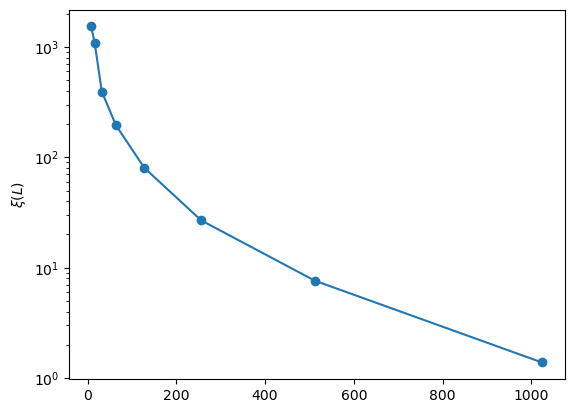

In [21]:
Nbin=8
L = s.domain['dx'][0]*2**np.arange(Nbin)
corr = get_correlation(SigmaSFR,return_map=False)
plt.plot(L,corr,'o-')
plt.ylabel(r'$\xi(L)$')
plt.yscale('log')

In [31]:
# I also want to obtain a plot of how SigmaSFR_Halpha varies with different resolutions
# PROBLEM: with this kind of calculation, the average value of SigmaSFR_Halpha over different grids is always the same

dx = s.domain['dx'][0]
Sigma_down_avg = []
for i in range(8):
    Sigma_down = rebin(SigmaSFR,i)
    # print(Sigma_down)
    idx = np.where(Sigma_down != 0)
    Sigma_down_nonzero = Sigma_down[idx]
    #print(Sigma_down_nonzero)
    Sigma_down_avg.append(Sigma_down_nonzero.mean())
    # Sigma_down_mean= Sigma_down.mean()
    #print(Sigma_down_avg)
    #Sigma_down_mean = np.average(Sigma_down, i)
    # plt.plot(dx*2**i,Sigma_down_mean)

print(Sigma_down_avg)

[<Quantity 1.37114095e-08 erg>, <Quantity 1.37114095e-08 erg>, <Quantity 1.37114095e-08 erg>, <Quantity 1.37114095e-08 erg>, <Quantity 1.37114095e-08 erg>, <Quantity 1.37114095e-08 erg>, <Quantity 1.37114095e-08 erg>, <Quantity 1.37114095e-08 erg>]


TypeError: only dimensionless scalar quantities can be converted to Python scalars

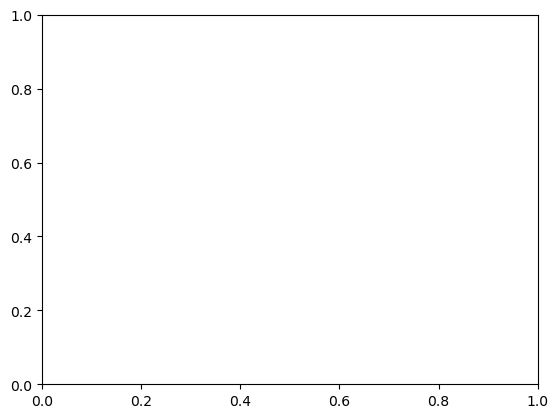

In [30]:
plt.plot(np.log10(L),Sigma_down_avg,label = 'SFR from Halpha') 

#plt.plot(np.log10(L),np.log10(sigmaSFR_avg_sp))
# vx = np.logspace(1,3.01029996,100)
# vy = (4.5e3)*vx**(-2)
# plt.plot(np.log10(vx),np.log10(vy),'--', label = 'slope -2')

plt.xlabel('L(pc)')
plt.ylabel(r'$\log(SFR)$')
plt.legend()